In [1]:
import numpy as np
from scipy.stats import norm, t, chi2, bernoulli, multivariate_normal, f

import matplotlib.pyplot as plt
from matplotlib import cm, rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# II. Variance

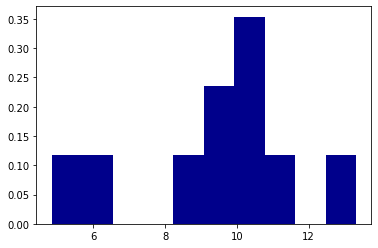

In [2]:
MU = 10
SIGMA = 2
SIZE = 10

SAMPLE = norm.rvs(MU, SIGMA, SIZE)

plt.hist(SAMPLE, density=True, histtype='stepfilled', color='darkblue')
plt.show()

## Confidence interval for population variance $\sigma^2$ with unknown population mean

$$
\left( \sigma^2 \right)_{1 - \alpha} \in \left( \dfrac{(n-1) s^2}{\chi^2_{n-1; \; \alpha/2}}, \dfrac{(n-1) s^2}{\chi^2_{n-1; \; 1 - \alpha/2}} \right)
$$

In [3]:
def sample_mean(sample):
    
    return np.mean(sample)

def sample_std(sample):
    
    n = len(sample)
    
    return np.sqrt((np.sum(sample**2) - n * sample_mean(sample)**2) / (n - 1))

def critical_value_chi(df, tail):
    
    return chi2.isf(tail, df)

def CI_variance__mean_unknown(sample, alpha):
    
    n              = len(sample)
    s              = sample_std(sample)
    chi_crit_right = critical_value_chi(n-1, alpha / 2)
    chi_crit_left  = critical_value_chi(n-1, 1 - alpha / 2)
    
    lower_bound = (n-1) * s**2 / chi_crit_right
    upper_bound = (n-1) * s**2 / chi_crit_left
    
    return (lower_bound, upper_bound)

In [4]:
ALPHA = 0.05

SAMPLE = norm.rvs(MU, SIGMA, SIZE)

print(CI_variance__mean_unknown(SAMPLE, ALPHA))

(1.9903342129743962, 14.020816469394315)


In [5]:
SIZE = 1000

SAMPLE = norm.rvs(MU, SIGMA, SIZE)

print(CI_variance__mean_unknown(SAMPLE, ALPHA))

(3.3609147251720515, 4.005593140575217)


## Confidence interval for population variance $\sigma^2$ with known population mean $\mu$

$$
\left( \sigma^2 \right)_{1 - \alpha} \in \left( \dfrac{\sum\limits_{i=1}^n \left( X_i - \mu \right)^2}{\chi^2_{n; \; \alpha/2}}, \dfrac{\sum\limits_{i=1}^n \left( X_i - \mu \right)^2}{\chi^2_{n; \; 1 - \alpha/2}} \right)
$$

In [6]:
def CI_variance__mean_known(sample, mu, alpha):
    
    n              = len(sample)
    sum_sqr        = np.sum((sample - mu)**2)
    chi_crit_right = critical_value_chi(n, alpha / 2)
    chi_crit_left  = critical_value_chi(n, 1 - alpha / 2)
    
    lower_bound = sum_sqr / chi_crit_right
    upper_bound = sum_sqr / chi_crit_left
    
    return (lower_bound, upper_bound)

In [7]:
print(CI_variance__mean_known(SAMPLE, MU, ALPHA))

(3.361554451332245, 4.0060036440324795)


# III. Proportion

### Samples of Bernoulli trials

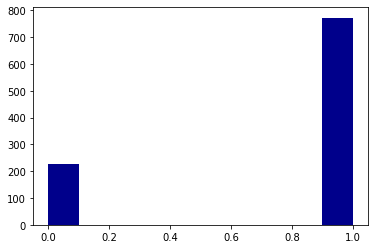

In [8]:
SUCCESS = 0.8
SIZE = 1000

SAMPLE = bernoulli.rvs(SUCCESS, size=SIZE)

plt.hist(SAMPLE, histtype='stepfilled', color='darkblue')
plt.show()

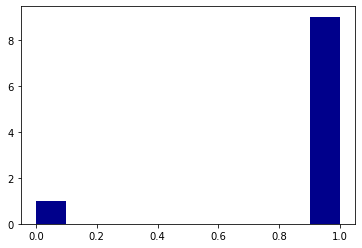

In [9]:
SIZE = 10

SAMPLE = bernoulli.rvs(SUCCESS, size=SIZE)

plt.hist(SAMPLE, histtype='stepfilled', color='darkblue')
plt.show()

## Confidence interval for population proportion $p$

$$
\left( p \right)_{1 - \alpha} \in \hat{p} \pm z_{\alpha / 2} \cdot \sqrt{\dfrac{\hat{p} \left( 1 - \hat{p} \right)}{n}}
$$

In [10]:
def sample_proportion(sample):
    
    return np.mean(sample)

def estimated_sample_proportion_std(sample):
    
    p_hat = sample_proportion(sample)
    
    return np.sqrt(p_hat * (1 - p_hat) / len(sample))

def critical_value_z(alpha):
    
    return norm.isf(alpha / 2)

def CI_proportion(sample, alpha):
    
    p_hat  = sample_proportion(sample)
    ese    = estimated_sample_proportion_std(sample)
    z_crit = critical_value_z(alpha)
    
    lower_bound = p_hat - z_crit * ese
    upper_bound = p_hat + z_crit * ese
    
    return (lower_bound, upper_bound)

In [11]:
ALPHA = 0.05

SAMPLE = bernoulli.rvs(SUCCESS, size=SIZE)

print(CI_proportion(SAMPLE, ALPHA))

(0.5520819870781754, 1.0479180129218246)


## Checking for ability to approximate with normal distribution

$$
\left\{
\begin{aligned}
n \hat{p} &\geq 5,\\
n (1 - \hat{p}) &\geq 5.\\
\end{aligned}
\right.
$$

In [12]:
def is_sample_proportion_approx(sample):
    
    p_hat  = sample_proportion(sample)
    n      = len(sample)
    
    p_cond = n * p_hat >= 5
    q_cond = n * (1 - p_hat) >= 5
    
    return p_cond and q_cond

In [13]:
print(is_sample_proportion_approx(SAMPLE))

False


### Increasing sample size

In [14]:
SIZE = 30

SAMPLE = bernoulli.rvs(SUCCESS, size=SIZE)

print(is_sample_proportion_approx(SAMPLE))

False


In [15]:
print(CI_proportion(SAMPLE, ALPHA))

(0.7926483513769705, 1.0073516486230294)


# IV. Difference of proportions

## Confidence interval for difference of population proportions $p_x - p_y$

$$
\left( p_x - p_y \right)_{1 - \alpha} \in \hat{p}_x - \hat{p}_y \pm z_{\alpha / 2} \cdot \sqrt{\dfrac{\hat{p}_x \left( 1 - \hat{p}_x \right)}{n_x} + \dfrac{\hat{p}_y \left( 1 - \hat{p}_y \right)}{n_y}}
$$
when
$$
\left\{
\begin{aligned}
n_x \hat{p}_x &\geq 5,\\
n_x (1 - \hat{p}_x) &\geq 5,\\
\end{aligned}
\right.
\qquad \text{and} \qquad
\left\{
\begin{aligned}
n_y \hat{p}_y &\geq 5,\\
n_y (1 - \hat{p}_y) &\geq 5.\\
\end{aligned}
\right.
$$

In [16]:
def CI_proportion_difference(sample_x, sample_y, alpha):
    
    p_hat_x  = sample_proportion(sample_x)
    ese_x    = estimated_sample_proportion_std(sample_x)
    
    p_hat_y  = sample_proportion(sample_y)
    ese_y    = estimated_sample_proportion_std(sample_y)
    
    p_hat_xy = p_hat_x - p_hat_y
    ese_xy   = np.sqrt(ese_x**2 + ese_y**2)
    
    z_crit   = critical_value_z(alpha)
    
    lower_bound = p_hat_xy - z_crit * ese_xy
    upper_bound = p_hat_xy + z_crit * ese_xy
    
    return (lower_bound, upper_bound)

In [17]:
SAMPLE_X = bernoulli.rvs(SUCCESS, size=SIZE)
SAMPLE_Y = bernoulli.rvs(SUCCESS, size=SIZE)

print(is_sample_proportion_approx(SAMPLE_X) and is_sample_proportion_approx(SAMPLE_Y))

True


In [18]:
print(CI_proportion_difference(SAMPLE_X, SAMPLE_Y, ALPHA))

(-0.20242420990106566, 0.20242420990106566)


### Different population proportions

In [19]:
SIZE_X = 40
SIZE_Y = 45

SUCCESS_X = 0.7
SUCCESS_Y = 0.9

SAMPLE_X = bernoulli.rvs(SUCCESS_X, size=SIZE_X)
SAMPLE_Y = bernoulli.rvs(SUCCESS_Y, size=SIZE_Y)

print(is_sample_proportion_approx(SAMPLE_X) and is_sample_proportion_approx(SAMPLE_Y))

True


In [20]:
print(CI_proportion_difference(SAMPLE_X, SAMPLE_Y, ALPHA))

(-0.41289889544897607, -0.06487888232880154)


### Inclusion of zero

In [21]:
SIZE_X = 80
SIZE_Y = 95

SUCCESS_X = 0.7
SUCCESS_Y = 0.8

SAMPLE_X = bernoulli.rvs(SUCCESS_X, size=SIZE_X)
SAMPLE_Y = bernoulli.rvs(SUCCESS_Y, size=SIZE_Y)

print(CI_proportion_difference(SAMPLE_X, SAMPLE_Y, ALPHA))

(-0.2985445857011825, -0.030402782719870153)


In [22]:
ALPHA = 0.1

print(CI_proportion_difference(SAMPLE_X, SAMPLE_Y, ALPHA))

(-0.2769895316062174, -0.051957836814835234)


# V. Difference of means

## Confidence interval for difference of population means $\mu_x - \mu_y$ with paired samples

$$
\left( \mu_x - \mu_y \right)_{1 - \alpha} \in \overline{D} \pm t_{n-1; \; \alpha / 2} \cdot \dfrac{s_D}{\sqrt{n}}
$$
where
$$
X \sim \mathcal{N} (\mu_x, \sigma^2), \qquad
Y \sim \mathcal{N} (\mu_y, \sigma^2), \qquad
D_i = X_i - Y_i, \qquad n_x = n_y = n
$$

In [23]:
def critical_value_t(df, alpha):
    
    return t.isf(alpha / 2, df)

def CI_mean_difference__paired_samples(sample_x, sample_y, alpha):
    
    sample_d = sample_x - sample_y
    
    d_bar  = sample_mean(sample_d)
    n      = len(sample_d)
    s_d    = sample_std(sample_d)
    t_crit = critical_value_t(n-1, alpha)
    
    lower_bound = d_bar - t_crit * s_d / np.sqrt(n)
    upper_bound = d_bar + t_crit * s_d / np.sqrt(n)
    
    return (lower_bound, upper_bound)

In [24]:
SIZE = 10

SAMPLE_X_paired = norm.rvs(MU, SIGMA, SIZE)
SAMPLE_Y_paired = SAMPLE_X_paired + norm.rvs(1, 1, SIZE)

print(CI_mean_difference__paired_samples(SAMPLE_X_paired, SAMPLE_Y_paired, ALPHA))

(-1.9248035359271163, -0.6214393433770207)


## Confidence interval for difference of population means $\mu_x - \mu_y$ with independent samples and known variances $\sigma^2_x$, $\sigma^2_y$

$$
\left( \mu_x - \mu_y \right)_{1 - \alpha} \in \overline{X} - \overline{Y} \pm z_{\alpha / 2} \cdot \sqrt{\dfrac{\sigma^2_x}{n_x} + \dfrac{\sigma^2_y}{n_y}}
$$

In [25]:
def CI_mean_difference__indep_samples__var_known(sample_x, sample_y, sigma_x, sigma_y, alpha):
    
    x_bar  = sample_mean(sample_x)
    n_x    = len(sample_x)
    
    y_bar  = sample_mean(sample_y)
    n_y    = len(sample_y)
    
    xy_bar = x_bar - y_bar
    se_xy  = np.sqrt(sigma_x**2 / n_x + sigma_y**2 / n_y)
    
    z_crit   = critical_value_z(alpha)
    
    lower_bound = xy_bar - z_crit * se_xy
    upper_bound = xy_bar + z_crit * se_xy
    
    return (lower_bound, upper_bound)

In [26]:
SIGMA_X = 2
SIGMA_Y = 4

SAMPLE_X = norm.rvs(MU, SIGMA_X, SIZE)
SAMPLE_Y = norm.rvs(MU, SIGMA_Y, SIZE)

print(CI_mean_difference__indep_samples__var_known(SAMPLE_X, SAMPLE_Y, SIGMA_X, SIGMA_Y, ALPHA))

(-2.8948046982147937, 1.7575439164919033)


## Confidence interval for difference of population means $\mu_x - \mu_y$ with independent samples and unknown equal variances $\sigma^2_x = \sigma^2_y = \sigma^2$

$$
\left( \mu_x - \mu_y \right)_{1 - \alpha} \in \overline{X} - \overline{Y} \pm t_{n_x + n_y -2; \; \alpha / 2} \cdot s_p \cdot \sqrt{\dfrac{1}{n_x} + \dfrac{1}{n_y}}
$$
where
$$
s^2_p = \dfrac{s^2_x \cdot (n_x - 1) + s^2_y \cdot (n_y - 1)}{n_x + n_y - 2}
$$

In [27]:
def sample_std_pooled(sample_x, sample_y):
    
    s_x = sample_std(sample_x)
    n_x = len(sample_x)
    
    s_y = sample_std(sample_y)
    n_y = len(sample_y)
    
    return np.sqrt((s_x**2 * (n_x - 1) + s_y**2 * (n_y - 1)) / (n_x + n_y - 2))

def CI_mean_difference__indep_samples__var_unknown_equal(sample_x, sample_y, alpha):
    
    x_bar  = sample_mean(sample_x)
    n_x    = len(sample_x)
    
    y_bar  = sample_mean(sample_y)
    n_y    = len(sample_y)
    
    xy_bar = x_bar - y_bar
    se_xy  = sample_std_pooled(sample_x, sample_y) * np.sqrt(1 / n_x + 1 / n_y)
    
    t_crit   = critical_value_t(n_x + n_y - 2, alpha)
    
    lower_bound = xy_bar - t_crit * se_xy
    upper_bound = xy_bar + t_crit * se_xy
    
    return (lower_bound, upper_bound)

In [28]:
print(CI_mean_difference__indep_samples__var_unknown_equal(SAMPLE_X_paired, SAMPLE_Y_paired, ALPHA))

(-3.536463039942541, 0.9902201606383993)
